# Analyses for Inpatient Prospective Payment System (IPPS)
The API information can be accessed through this [link](https://data.cms.gov/Medicare-Inpatient/Inpatient-Prospective-Payment-System-IPPS-Provider/97k6-zzx3)

<b>Question 1:</b> Can we infer meaningful correlations between the number of providers and the number of procedures done on average provider charge?

<b>Question 2:</b> Medicare and patients don't pay the full amount charged by the provider. Does this differ by state?

----

## Question 1: Can we infer meaningful correlations between the number of providers and the number of procedures done on average provider charge?


### Configuring Matplotlib and Calling Required Packages and .csv Files

In [1]:
# Configuring matplotlib
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

# Required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sodapy import Socrata

In [2]:
results_df = pd.read_csv('/Users/hasansulaeman/team_ipps/Resources/raw_ipps.csv')
resultG = pd.read_csv('/Users/hasansulaeman/team_ipps/Resources/summary_ipps.csv')

### Determining which procedures are the most common in which state

In [3]:
# Group results by "provider_state" and "drg_definition"
resultGB = results_df.groupby(["provider_state","drg_definition"])

# Count number of provider_id and rename provider_id column
resultGB = pd.DataFrame(resultGB["provider_id"].count())
resultGB.rename(columns = {"provider_id": "Count"}, inplace = True)

# Reset index and sort values by "Provider Count" descending
resultGB = resultGB.reset_index()
resultGB = resultGB.sort_values(by="Count", ascending=False)

# Eliminating duplicates while keeping the first occurance by "provider_state"
resultGB = resultGB.drop_duplicates(subset="provider_state", keep="first").reset_index(drop=True)
resultGB = resultGB.rename(columns = {"provider_state":"State","drg_definition":"Diagnosis"})

# Determine the highest provider count for the top 5 States
resultGB.head()

,State,Diagnosis,Count
0,CA,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,273
1,TX,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,255
2,FL,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,165
3,NY,292 - HEART FAILURE & SHOCK W CC,158
4,PA,292 - HEART FAILURE & SHOCK W CC,139


###  Average charge by provider as a function of number of procedures done (state level)

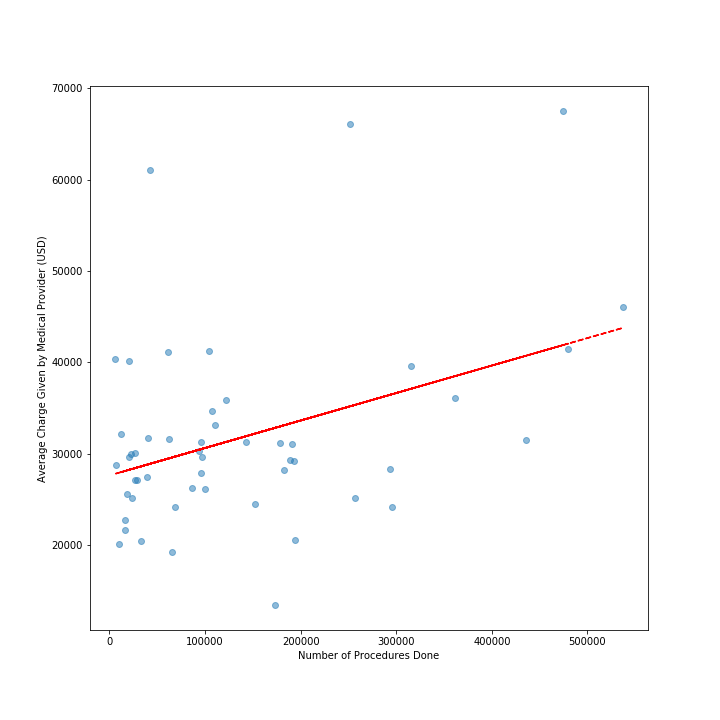

In [5]:
# Setting the figure size
plt.figure(figsize=(10,10))

# Making the plot
plt.scatter(resultG['total_discharges'], resultG['average_covered_charges'], alpha=0.5)

# Getting a trendline
z = np.polyfit(resultG['total_discharges'], resultG['average_covered_charges'], 1)
p = np.poly1d(z)
plt.plot(resultG['total_discharges'],p(resultG['total_discharges']),"r--")

# Setting the descriptions
plt.ylabel('Average Charge Given by Medical Provider (USD)')
plt.xlabel('Number of Procedures Done')
plt.savefig('fig1.png')

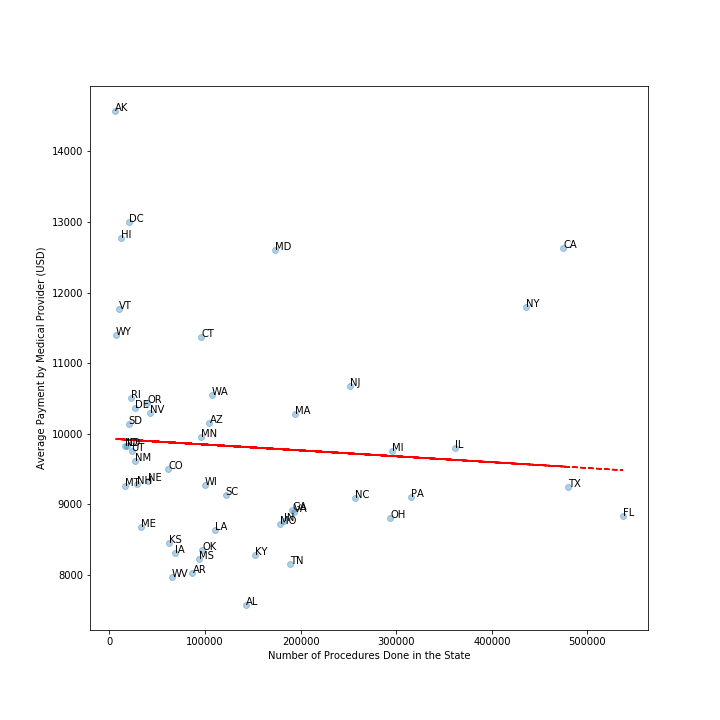

In [6]:
# Setting the figure size
plt.figure(figsize=(10,10))

# Making the plot
plt.scatter(resultG['total_discharges'], resultG['average_medicare_payments'], alpha=0.35)
for i, txt in enumerate(resultG['provider_state']):
    plt.annotate(txt, (resultG['total_discharges'][i], resultG['average_medicare_payments'][i]))

# Getting a trendline
z = np.polyfit(resultG['total_discharges'], resultG['average_medicare_payments'], 1)
p = np.poly1d(z)
plt.plot(resultG['total_discharges'],p(resultG['total_discharges']),"r--")

# Setting the descriptions
plt.ylabel('Average Payment by Medical Provider (USD)')
plt.xlabel('Number of Procedures Done in the State')
plt.savefig('fig2.png')

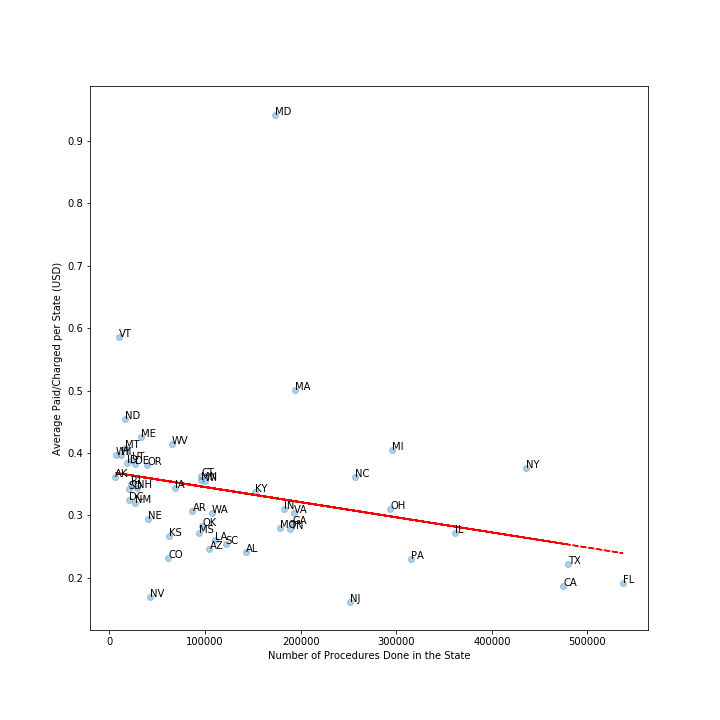

In [7]:
# Getting the ratio
resultG['ratio'] = resultG['average_medicare_payments']/resultG['average_covered_charges']

# Setting the figure size
plt.figure(figsize=(10,10))

# Making the plot
plt.scatter(resultG['total_discharges'], resultG['ratio'], alpha=0.35)
for i, txt in enumerate(resultG['provider_state']):
    plt.annotate(txt, (resultG['total_discharges'][i], resultG['ratio'][i]))

# Getting a trendline
z = np.polyfit(resultG['total_discharges'], resultG['ratio'], 1)
p = np.poly1d(z)
plt.plot(resultG['total_discharges'],p(resultG['total_discharges']),"r--")

# Setting the descriptions
plt.ylabel('Average Paid/Charged per State (USD)')
plt.xlabel('Number of Procedures Done in the State')
plt.savefig('fig3.png')

## Setting up a new data frame (don't know why we're doing this but i cant find & replace on all cells so it's staying)

In [9]:
# Selecting certain columns from results_df
proce_vs_cost = results_df[["provider_state", "average_covered_charges", "drg_definition", "total_discharges"]]

# Equation used to find "Cost Per Discharge"
proce_vs_cost = proce_vs_cost.rename(columns={"provider_state":"State", 
                                              "drg_definition":"Diagnosis",
                                              "average_covered_charges":"Provider's Avg Charge Covered by Medicare",
                                              "total_discharges":"Total Discharges"})
proce_vs_cost.head()

,State,Provider's Avg Charge Covered by Medicare,Diagnosis,Total Discharges
0,AL,32963.07,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,91
1,AL,15131.85,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,14
2,AL,37560.37,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,24
3,AL,13998.28,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,25
4,AL,31633.27,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,18


----
#### No. 1 CA (871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W MCC)

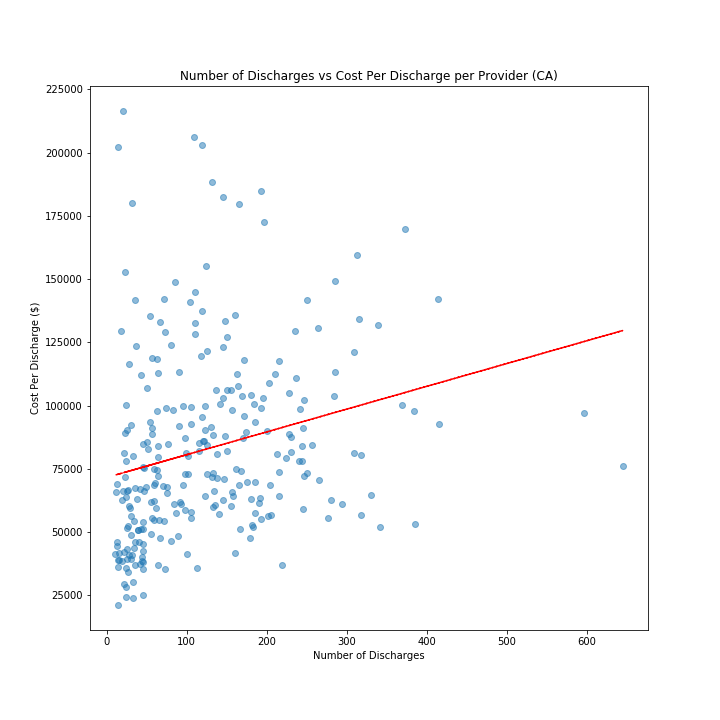

In [10]:
# Extracting CA with Diagnosis 871 from DataFrame
CA_state = proce_vs_cost[proce_vs_cost["State"] == "CA"]
CA_state_871 = CA_state[CA_state["Diagnosis"] == "871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W MCC"].reset_index(drop=True)

# Setting the figure size
plt.figure(figsize=(10,10))

# Defining x and y values for plot
x = CA_state_871["Total Discharges"]
y = CA_state_871["Provider's Avg Charge Covered by Medicare"]

# Scatter plot. Where x is the number of discharges and y is the cost per discharge
plt.scatter(x, y, alpha=0.5)
plt.title("Number of Discharges vs Cost Per Discharge per Provider (CA)")
plt.xlabel("Number of Discharges")
plt.ylabel("Cost Per Discharge ($)")

# Adding trendline for scatter plot
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.savefig('fig4.png')

##### Top No. 2 TX (690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC)

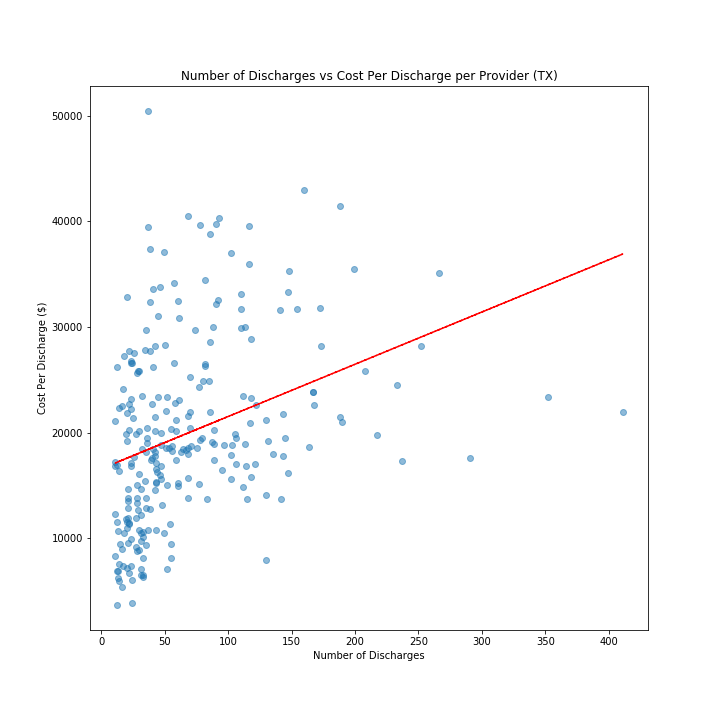

In [12]:
# Extracting TX with Diagnosis 690 from DataFrame
TX_state = proce_vs_cost[proce_vs_cost["State"] == "TX"].reset_index(drop=True)
TX_state_690 = TX_state[TX_state["Diagnosis"] == "690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC"].reset_index(drop=True)

# Setting the figure size
plt.figure(figsize=(10,10))

# Defining x and y values for plot
x = TX_state_690["Total Discharges"]
y = TX_state_690["Provider's Avg Charge Covered by Medicare"]

# Scatter plot. Where x is the number of discharges and y is the cost per discharge
plt.scatter(x, y, alpha=0.5)
plt.title("Number of Discharges vs Cost Per Discharge per Provider (TX)")
plt.xlabel("Number of Discharges")
plt.ylabel("Cost Per Discharge ($)")

# Adding trendline for scatter plot
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.savefig('fig5.png')

##### Top No. 3 FL (690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC)

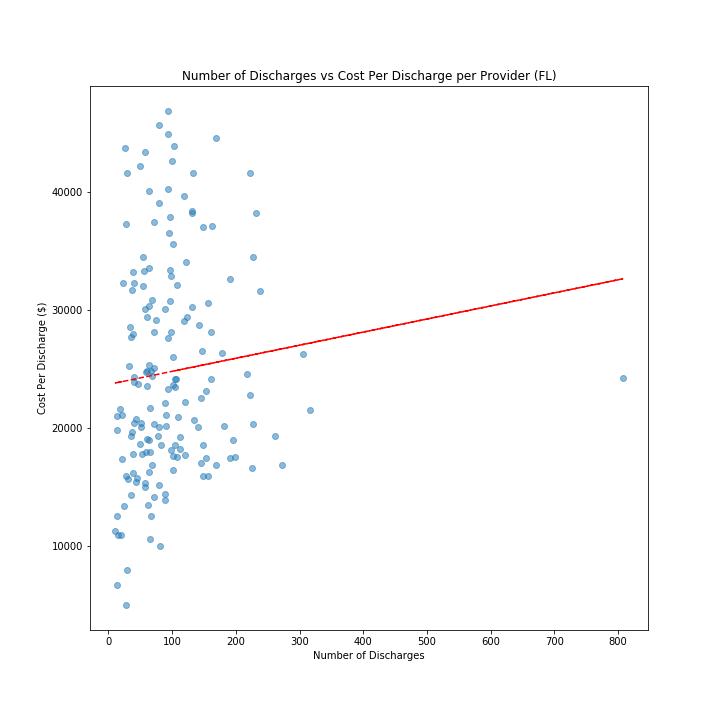

In [13]:
# Extracting FL with Diagnosis 690 from DataFrame
FL_state = proce_vs_cost[proce_vs_cost["State"] == "FL"].reset_index(drop=True)
FL_state_690 = FL_state[FL_state["Diagnosis"] == "690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC"].reset_index(drop=True)

# Setting the figure size
plt.figure(figsize=(10,10))

# Defining x and y values for plot
x = FL_state_690["Total Discharges"]
y = FL_state_690["Provider's Avg Charge Covered by Medicare"]

# Scatter plot. Where x is the number of discharges and y is the cost per discharge
plt.scatter(x, y, alpha=0.5)
plt.title("Number of Discharges vs Cost Per Discharge per Provider (FL)")
plt.xlabel("Number of Discharges")
plt.ylabel("Cost Per Discharge ($)")

# Adding trendline for scatter plot
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.savefig('fig6.png')

##### Top No. 4 NY (292 - HEART FAILURE & SHOCK W CC)

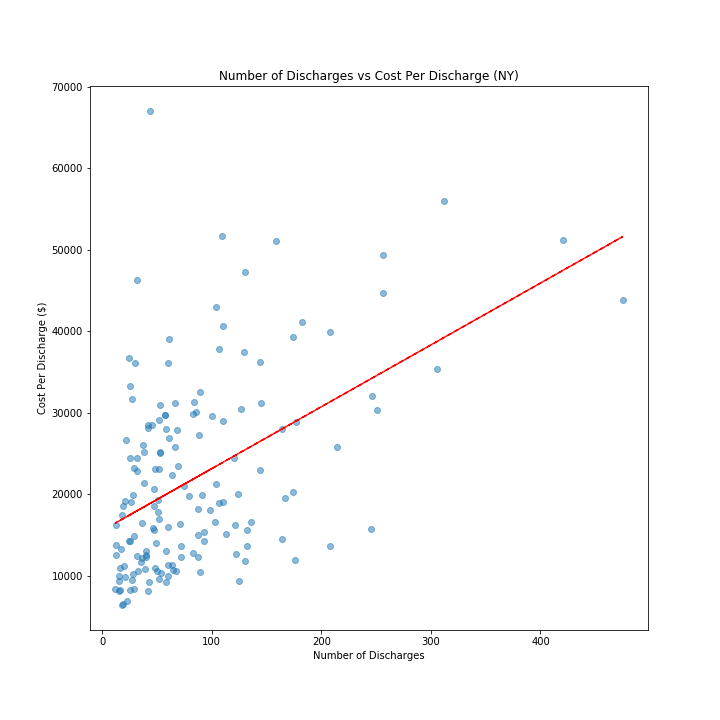

In [14]:
# Extracting NY with Diagnosis 292 from DataFrame
NY_state = proce_vs_cost[proce_vs_cost["State"] == "NY"].reset_index(drop=True)
NY_state_292 = NY_state[NY_state["Diagnosis"] == "292 - HEART FAILURE & SHOCK W CC"].reset_index(drop=True)

# Setting the figure size
plt.figure(figsize=(10,10))

# Defining x and y values for plot
x = NY_state_292["Total Discharges"]
y = NY_state_292["Provider's Avg Charge Covered by Medicare"]

# Scatter plot. Where x is the number of discharges and y is the cost per discharge
plt.scatter(x, y, alpha=0.5)
plt.title("Number of Discharges vs Cost Per Discharge (NY)")
plt.xlabel("Number of Discharges")
plt.ylabel("Cost Per Discharge ($)")

# Adding trendline for scatter plot
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.savefig('fig7.png')

##### Top No. 5 PA (292 - HEART FAILURE & SHOCK W CC)

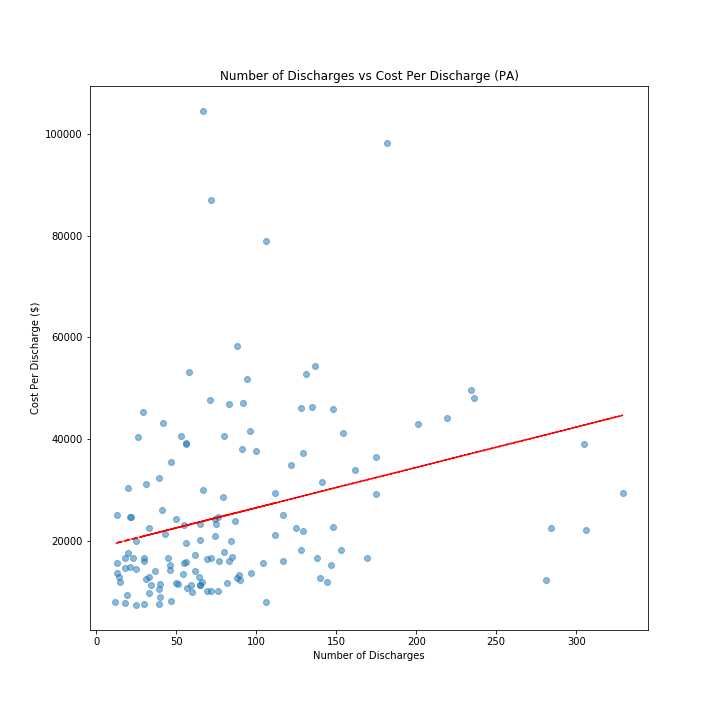

In [15]:
# Extracting PA with Diagnosis 292 from DataFrame
PA_state = proce_vs_cost[proce_vs_cost["State"] == "PA"].reset_index(drop=True)
PA_state_292 = PA_state[PA_state["Diagnosis"] == "292 - HEART FAILURE & SHOCK W CC"].reset_index(drop=True)

# Setting the figure size
plt.figure(figsize=(10,10))

# Defining x and y values for plot
x = PA_state_292["Total Discharges"]
y = PA_state_292["Provider's Avg Charge Covered by Medicare"]

# Scatter plot. Where x is the number of discharges and y is the cost per discharge
plt.scatter(x, y, alpha=0.5)
plt.title("Number of Discharges vs Cost Per Discharge (PA)")
plt.xlabel("Number of Discharges")
plt.ylabel("Cost Per Discharge ($)")

# Adding trendline for scatter plot
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.savefig('fig8.png')

### Average charge by provider as a function of number of providers in the state (state level)

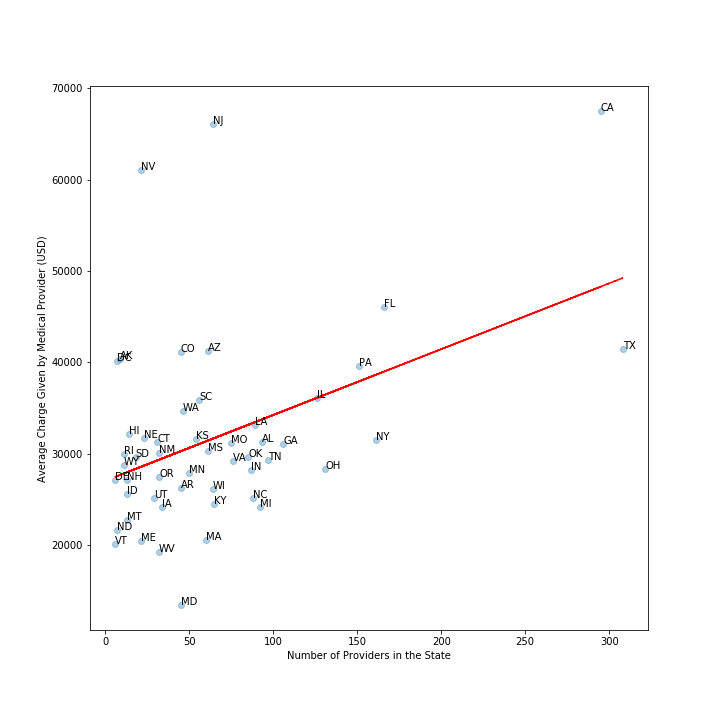

In [16]:
# Setting the figure size
plt.figure(figsize=(10,10))

# Making the plot
plt.scatter(resultG['provider_count'], resultG['average_covered_charges'], alpha=0.35)
for i, txt in enumerate(resultG['provider_state']):
    plt.annotate(txt, (resultG['provider_count'][i], resultG['average_covered_charges'][i]))

# Getting a trendline
z = np.polyfit(resultG['provider_count'], resultG['average_covered_charges'], 1)
p = np.poly1d(z)
plt.plot(resultG['provider_count'],p(resultG['provider_count']),"r--")

# Setting the descriptions
plt.ylabel('Average Charge Given by Medical Provider (USD)')
plt.xlabel('Number of Providers in the State')
plt.savefig('fig9.png')

### Average payment as a function of number of providers in the state (state level)

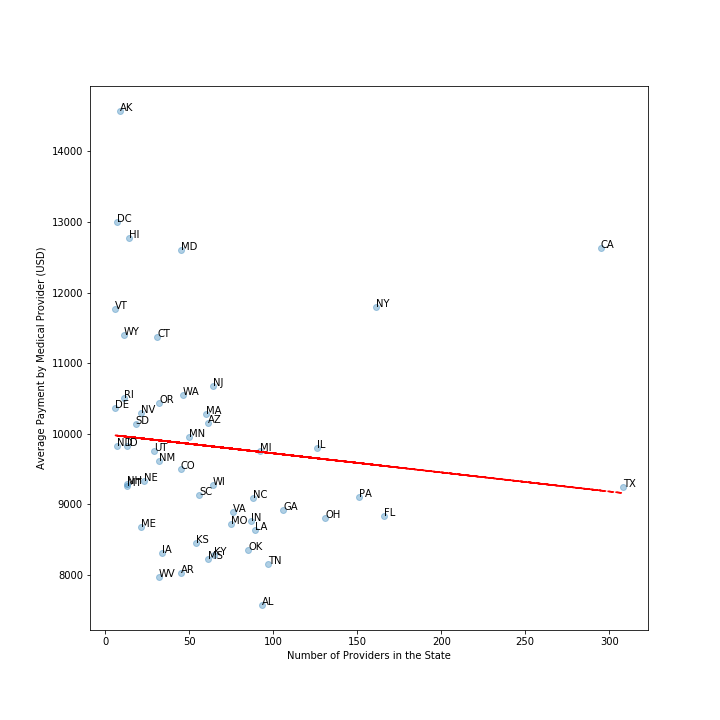

In [17]:
# Setting the figure size
plt.figure(figsize=(10,10))

# Making the plot
plt.scatter(resultG['provider_count'], resultG['average_medicare_payments'], alpha=0.35)
for i, txt in enumerate(resultG['provider_state']):
    plt.annotate(txt, (resultG['provider_count'][i], resultG['average_medicare_payments'][i]))

# Getting a trendline
z = np.polyfit(resultG['provider_count'], resultG['average_medicare_payments'], 1)
p = np.poly1d(z)
plt.plot(resultG['provider_count'],p(resultG['provider_count']),"r--")

# Setting the descriptions
plt.ylabel('Average Payment by Medical Provider (USD)')
plt.xlabel('Number of Providers in the State')
plt.savefig('fig10.png')

### Ratio of average charged/paid as a function of number of providers in the state (state level)

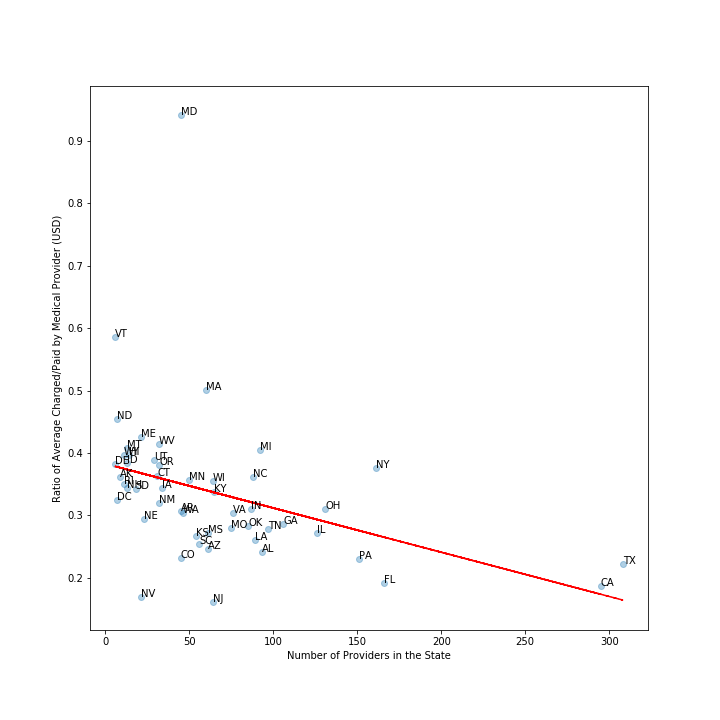

In [18]:
resultG['ratio'] = resultG['average_medicare_payments']/resultG['average_covered_charges']

# Setting the figure size
plt.figure(figsize=(10,10))

# Making the plot
plt.scatter(resultG['provider_count'], resultG['ratio'], alpha=0.35)
for i, txt in enumerate(resultG['provider_state']):
    plt.annotate(txt, (resultG['provider_count'][i], resultG['ratio'][i]))

# Getting a trendline
z = np.polyfit(resultG['provider_count'], resultG['ratio'], 1)
p = np.poly1d(z)
plt.plot(resultG['provider_count'],p(resultG['provider_count']),"r--")

# Setting the descriptions
plt.ylabel('Ratio of Average Charged/Paid by Medical Provider (USD)')
plt.xlabel('Number of Providers in the State')
plt.savefig('fig11.png')

### Ratio of average charged/paid per state

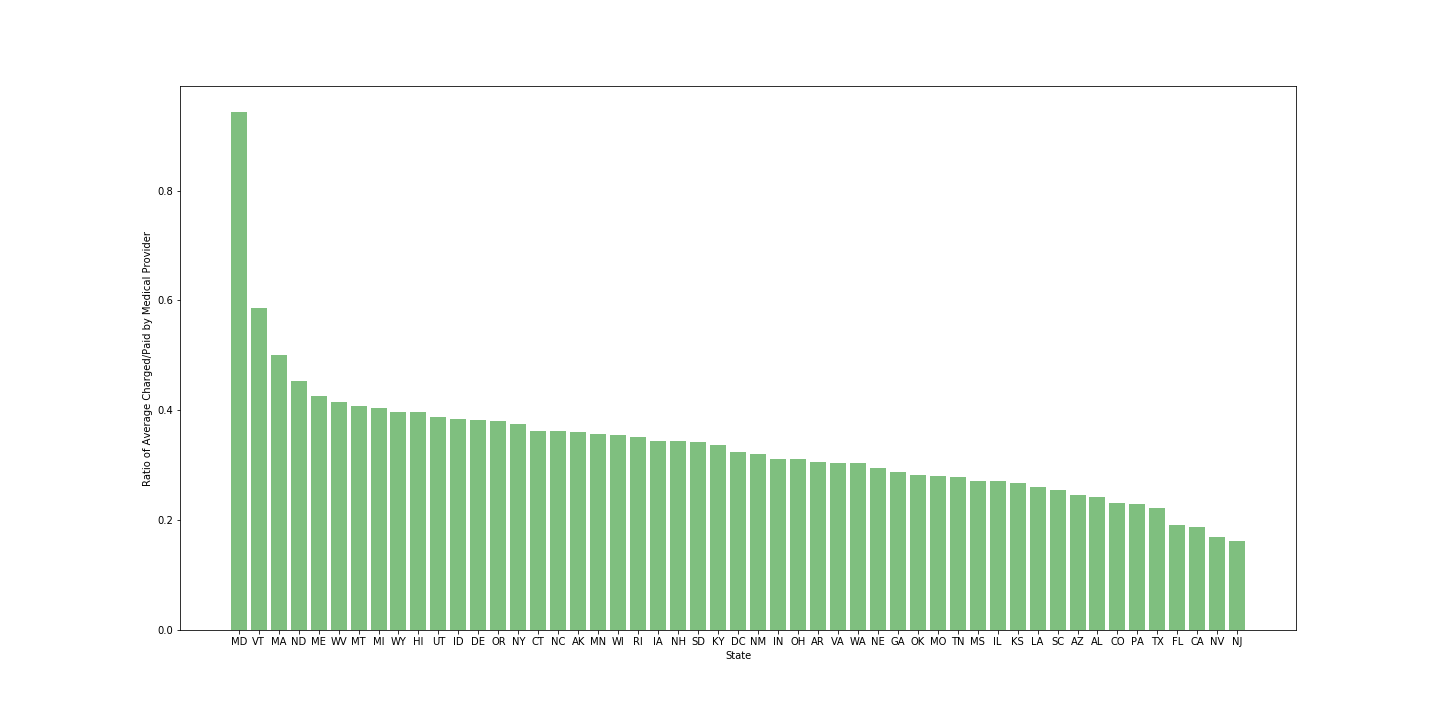

In [19]:
# Setting the figure size
plt.figure(figsize=(20,10))

# Sorting manually 
resultG = resultG.sort_values(by='ratio', ascending=False).reset_index(drop=True)

# Drawing the plot
plt.bar(resultG.index, resultG['ratio'] , alpha=0.5, color="g")
plt.xticks(resultG.index, resultG['provider_state'])
plt.ylabel('Ratio of Average Charged/Paid by Medical Provider')
plt.xlabel('State')
plt.savefig('fig12.png')